# Results Analysis

## Metric Choices
- [Google-BLEU (GLEU)](https://web.science.mq.edu.au/~rdale/publications/papers/2007/gleu4ps2pdf.pdf): Alternative to BLEU that often aligns better with human judgements on MT tasks. GLEU measures precision and recall of all 1-4 grams and choses the minimum of the two. 
- [Character n-gram F-score (CHRF)](http://www.statmt.org/wmt15/pdf/WMT49.pdf): 
$$ (1 + \beta^2) \frac{CHRP \times CHRR}{\beta^2 CHRP + CHHRR} $$
where $CHRP$ is the percentage of n-grams in the predicted sequence that are in the target sequence and $CHRR$ is the percentage of character n-grams in the predicted sequence that are also in the target sequence 
- [BiLingual Evaluation Understudy (BLEU)](https://www.aclweb.org/anthology/P02-1040.pdf):
- Formality: The average predicted confidence each sequence is formal. Computed by neural network trained on separate labelled informal/formal corpus. Result is average softmax prediction for formal output. This model was trained to 83% accuracy 

In [ ]:
import warnings
warnings.filterwarnings("ignore")  # nltk doesn't like 1gram bleu

In [61]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction, sentence_bleu
from nltk.translate.chrf_score import corpus_chrf
from nltk.translate.gleu_score import corpus_gleu

import pandas as pd
import numpy as np
import seaborn as sns

from metrics.formality_classifier import FormalityClassifier
from scipy.stats import ttest_rel as ttest
from scipy.stats import sem

In [3]:
formality_classifier = FormalityClassifier()

In [87]:
def load_and_score(results_file_path, actual_file_path, num_groups=7, val=False):
    def replace(seq):
        if seq is not None:
            return seq.replace('<start>', '').replace('<end>', '')
        else:
            return ' '
    # load data
    actual = open(actual_file_path).read()
    results = open(results_file_path).read()

    actual = [replace(seq) for seq in actual.split('\n')]
    results = [replace(seq) for seq in results.split('\n')]

    if val:
        actual = actual[:2000]
        results = results[:2000]

    # split data into test groups
    split_size = len(actual) // num_groups
    actual_split = [actual[x:x+split_size] for x in range(0, len(actual), split_size)]
    results_split = [results[x:x+split_size] for x in range(0, len(results), split_size)]
    
    
    
    s = SmoothingFunction().method5

    # loop through 
    formality, bleu, bleu_1gram, chrf, gleu = [], [], [], [], []
    for a, r in zip(actual_split, results_split):
        formality.append(formality_classifier.classify(r))
        bleu.append(corpus_bleu(a, r, smoothing_function=s))
        chrf.append(corpus_chrf(a, r))
        bleu_1gram.append(corpus_bleu(a, r, weights=(1,0,0,0)))
        gleu.append(corpus_gleu(a, r))
        

    df = pd.DataFrame(list(zip(bleu, bleu_1gram, chrf, formality, gleu)),
                      columns=['BLEU', 'BLEU (1-grams)', 'CHRF', 'FORMALITY', 'GLEU'])

    output = 'BLEU: {:4f} (+/) {:4f} | CHRF: {:4f} (+/) {:4f} | FORMALITY: {:4f} (+/) {:4f}| BLEU 1-grams: {:4f} (+/) {:4f} | GLEU: {:4f} (+/) {:4f}'
    print(output.format(np.mean(bleu), sem(bleu), 
                        np.mean(chrf), sem(chrf),
                        np.mean(formality), sem(formality),
                        np.mean(bleu_1gram), sem(bleu_1gram),
                        np.mean(gleu), sem(gleu)))
    return df * 100

In [88]:
def sig_test(df, baseline_df, alpha=0.01):
    for col in df.columns:
        pvalue = ttest(df[col], baseline_df[col]).pvalue
        if pvalue < alpha and df[col].mean() > baseline_df[col].mean():
            print('{} is significant!'.format(col))

In [89]:
BASE_PATH = 'Data/Results/'
actual = 'Data/Supervised Data/Entertainment_Music/S_Formal_EM_ValTest.txt'

## Sequence Base Models

### Global Attention Model

In [128]:
sig_test(ga_df, onmt_T_df)

GLEU is significant!


In [92]:
ga_df = load_and_score(BASE_PATH + 'global.txt', actual, val=True)

BLEU: 0.102009 (+/) 0.000672 | CHRF: 0.167098 (+/) 0.002891 | FORMALITY: 0.014798 (+/) 0.002587| BLEU 1-grams: 0.295078 (+/) 0.005237 | GLEU: 0.006585 (+/) 0.000089


### Bahdanau Attention
```
Informal:  <start> pretty woman but i cant remember who sings it .  <end>
Formal:  <start> The song is called Pretty Woman , but I cannot remember who sings it .  <end>
Predicted:  <start> i believe she is a woman i can not remember who sings the song <end> 
```

In [93]:
ba_df = load_and_score(BASE_PATH + 'Bahdanau_Attention_Results_Custom.txt', actual, val=True)

BLEU: 0.096138 (+/) 0.000694 | CHRF: 0.267478 (+/) 0.003424 | FORMALITY: 0.017787 (+/) 0.003165| BLEU 1-grams: 0.249321 (+/) 0.005413 | GLEU: 0.004643 (+/) 0.000083


In [94]:
sig_test(ba_df, ga_df)

CHRF is significant!


### Vanilla Encoder Decoder Custom
The vanilla encoder decoder feeds the sequences into encoder to learn a latent representation. The decoder then iterates through the original sequence and uses the latent representation to predict a next word. This model was trained for 30 epochs on 25,0000 sequences. 

In [95]:
ved_df = load_and_score(BASE_PATH + 'vanilla_encoder_decoder_results_custom.txt', actual, val=True)

BLEU: 0.123214 (+/) 0.000527 | CHRF: 0.046130 (+/) 0.004184 | FORMALITY: 0.003311 (+/) 0.000000| BLEU 1-grams: 0.460362 (+/) 0.004110 | GLEU: 0.017241 (+/) 0.000000


In [96]:
sig_test(ved_df, ga_df)

BLEU is significant!
BLEU (1-grams) is significant!
GLEU is significant!


### CRF Pos Concat with Global Attention

In [97]:
pos_concat = load_and_score(BASE_PATH + 'CRF_POS_Concat.txt', actual, val=True)

BLEU: 0.070417 (+/) 0.000184 | CHRF: 0.046345 (+/) 0.000662 | FORMALITY: 0.784879 (+/) 0.005180| BLEU 1-grams: 0.048845 (+/) 0.001438 | GLEU: 0.002350 (+/) 0.000038


In [98]:
sig_test(pos_concat, ga_df)

FORMALITY is significant!


### Rule Concat with Global Attention

In [99]:
rule_concat = load_and_score(BASE_PATH + 'Rule_Concat.txt', actual, val=True)

BLEU: 0.076149 (+/) 0.000551 | CHRF: 0.039527 (+/) 0.001894 | FORMALITY: 0.672131 (+/) 0.007569| BLEU 1-grams: 0.093525 (+/) 0.004291 | GLEU: 0.004831 (+/) 0.000365


In [100]:
sig_test(rule_concat, ga_df)

FORMALITY is significant!


### CRF POS Attention Average

In [101]:
crf_pos_avg = load_and_score(BASE_PATH + 'CRF_POS_Attention_Avg.txt', actual, val=True)

BLEU: 0.071036 (+/) 0.000186 | CHRF: 0.042105 (+/) 0.001434 | FORMALITY: 0.805436 (+/) 0.003425| BLEU 1-grams: 0.053668 (+/) 0.001449 | GLEU: 0.002665 (+/) 0.000114


In [133]:
sig_test(crf_pos_avg, pos_concat)

BLEU is significant!
BLEU (1-grams) is significant!
FORMALITY is significant!
GLEU is significant!


### Rule Avg with Global Attention

In [91]:
rule_avg = load_and_score(BASE_PATH + 'HA_results_avg.txt', actual, val=True)

BLEU: 0.075401 (+/) 0.000410 | CHRF: 0.043147 (+/) 0.001006 | FORMALITY: 0.694687 (+/) 0.016175| BLEU 1-grams: 0.087694 (+/) 0.003199 | GLEU: 0.004576 (+/) 0.000242


In [134]:
sig_test(ga_df, ba_df)

BLEU is significant!
BLEU (1-grams) is significant!
GLEU is significant!


## Transformer Based Models

### ONMT Transformer
ONMT transformer was trained on the first 2000 sequences of the test set, and the remaining sequences were used as validation.

In [12]:
onmt_T_df = load_and_score(BASE_PATH + 'onmt_transformer_output.txt', actual, val=True)

BLEU: 0.103840 (+/) 0.000721 | CHRF: 0.355626 (+/) 0.008902 | FORMALITY: 0.781321 (+/) 0.005226| BLEU 1-grams: 0.309349 (+/) 0.005623 | GLEU: 0.004960 (+/) 0.000071


In [55]:
sig_test(onmt_T_df, onmt_T_df)

### Back Translation Transformer

In [14]:
bt = load_and_score(BASE_PATH + 'back_translation.txt', actual, val=True)

BLEU: 0.107247 (+/) 0.000290 | CHRF: 0.097944 (+/) 0.001584 | FORMALITY: 0.756813 (+/) 0.009000| BLEU 1-grams: 0.335905 (+/) 0.002257 | GLEU: 0.006982 (+/) 0.000109


In [56]:
sig_test(bt, onmt_T_df)

BLEU is significant!
BLEU (1-grams) is significant!
GLEU is significant!


### CRF POS Model
The CRF POS was a model trained using [parallel encodings](https://arxiv.org/pdf/1804.09849.pdfhttps://arxiv.org/pdf/1804.09849.pdf)

In [16]:
crf_pos_df = load_and_score(BASE_PATH + 'crf_pos_seq2seq_predictions.txt', actual, val=True)

BLEU: 0.104796 (+/) 0.000659 | CHRF: 0.079112 (+/) 0.003467 | FORMALITY: 0.831928 (+/) 0.009777| BLEU 1-grams: 0.316804 (+/) 0.005138 | GLEU: 0.008301 (+/) 0.000083


In [57]:
sig_test(crf_pos_df, onmt_T_df)

FORMALITY is significant!
GLEU is significant!


### Transformer with Rules

In [17]:
rule_trans = load_and_score(BASE_PATH + 'rule_based_transformer.txt', actual, val=True)

BLEU: 0.105465 (+/) 0.000356 | CHRF: 0.131249 (+/) 0.003914 | FORMALITY: 0.875575 (+/) 0.004337| BLEU 1-grams: 0.322019 (+/) 0.002776 | GLEU: 0.006269 (+/) 0.000179


In [58]:
sig_test(rule_trans, onmt_T_df)

FORMALITY is significant!
GLEU is significant!


### Formality Discrimination

In [22]:
fd = load_and_score(BASE_PATH + 'formality_disrcimination.txt', actual, val=True)

BLEU: 0.111787 (+/) 0.000655 | CHRF: 0.267303 (+/) 0.005512 | FORMALITY: 0.758603 (+/) 0.015260| BLEU 1-grams: 0.371291 (+/) 0.005103 | GLEU: 0.006643 (+/) 0.000186


In [59]:
sig_test(fd, onmt_T_df)

BLEU is significant!
BLEU (1-grams) is significant!
GLEU is significant!


## Plots

In [33]:
def create_results_df(model_names, model_dfs):
    results = []
    for name, model in zip(model_names, models):
        for index, row in model.iterrows():
            results.append(['BLEU', name, row['BLEU']])
            results.append(['BLEU (1-grams)', name, row['BLEU (1-grams)']]) 
            results.append(['FORMALITY', name, row['FORMALITY']])
            results.append(['GLEU', name, row['GLEU']])
            results.append(['CHRF', name, row['CHRF']])
    
    df = pd.DataFrame(results, columns=['metric', 'model', 'result'])
    return df

In [121]:
# model_names = ['Transformer', 'Back Translation',
#                'Formality Discrimination', 'Rule-Assisted', 'POS-Assisted']
# models = [onmt_T_df, bt, fd, rule_trans, crf_pos_df]
model_names = ['Global Attention', 'Bahdanau Attention', 'POS (Concat)',
               'POS (Avg)', 'Rule (Concat)', 'Rule (Avg)']
models = [ga_df, ba_df, pos_concat, crf_pos_avg, rule_concat, rule_avg]
df = create_results_df(model_names, models)

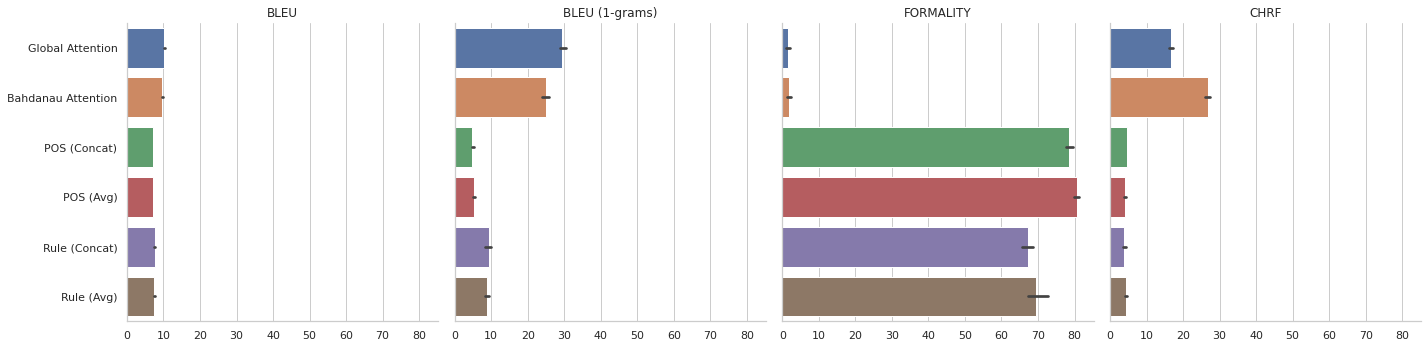

In [122]:
sns.set_theme(style="whitegrid")
ax = sns.catplot(x="result", y="model", col="metric", 
                data=df[df['metric'] != 'GLEU'], kind="bar", col_wrap=4)
(ax.set_axis_labels("", "")
 .set_titles("{col_name}"))

In [123]:
import matplotlib.pyplot as plt

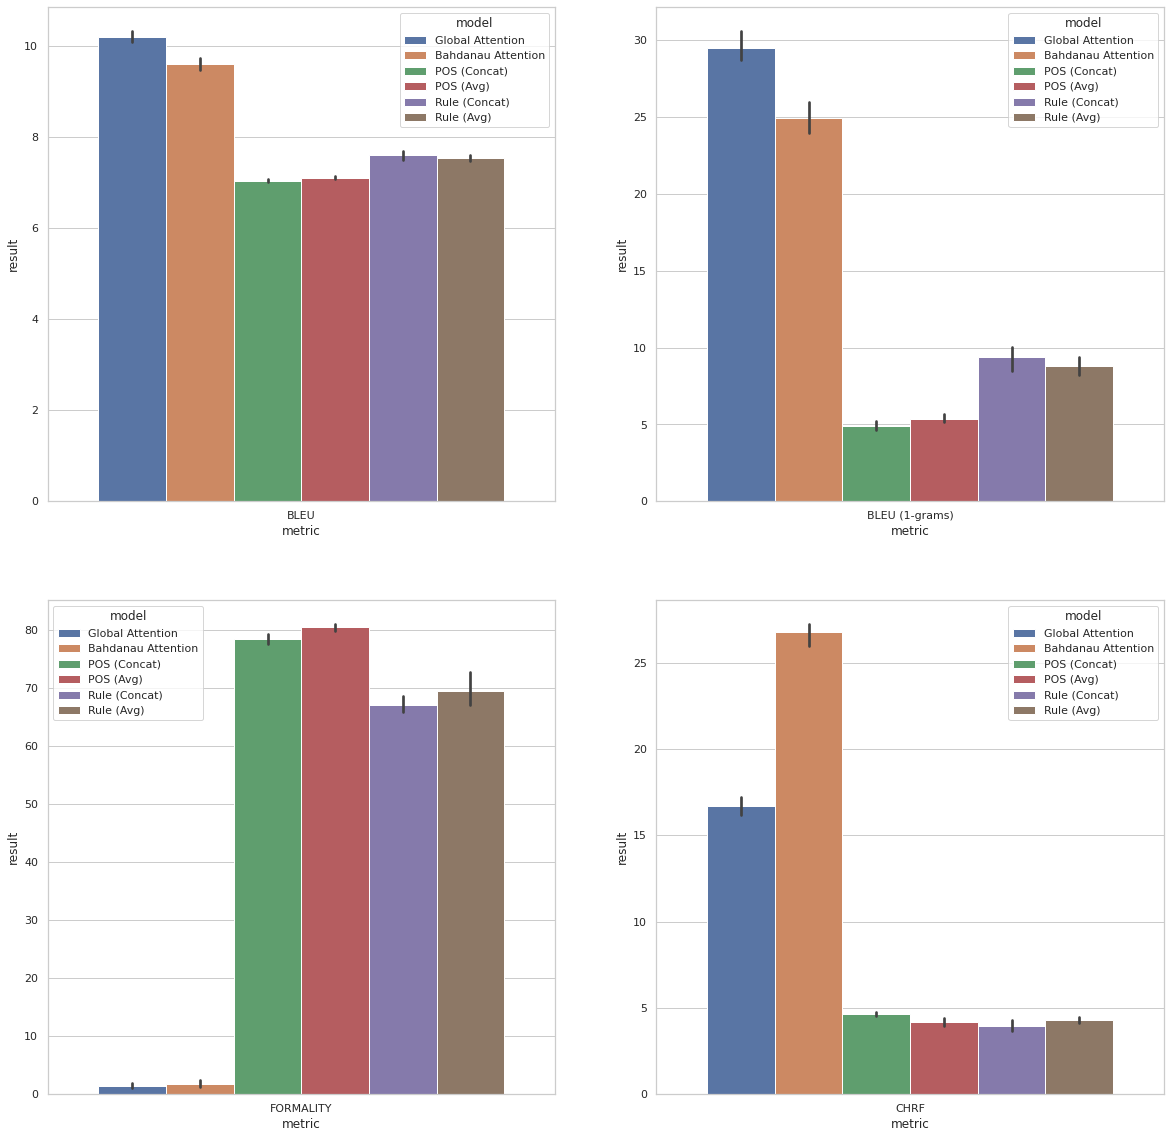

In [126]:
fig, ax = plt.subplots(2,2, figsize=(20, 20))

# handles, labels = ax.get_legend_labels()

for a, metric in zip(fig.axes, ['BLEU', 'BLEU (1-grams)', 'FORMALITY', 'CHRF']):
    g = sns.barplot(x='metric', y='result', hue="model"  ,
                    data=df[df['metric'] == metric], ax=a)
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     if metric in ['BLEU']:
#         g.legend(loc="lower left")
        
#     if metric in ['FORMALITY']:
#         g.legend(loc="upper left")
        
#     if metric in ['BLEU (1-grams)']:
#         g.legend(loc="upper right")
        
#     g.set(xticks=[])
    
    
plt.show()